In [52]:
library(tidyverse)
theme_set(theme_classic())
options(repr.plot.width=10, repr.plot.height=5, repr.plot.dpi=300)

# STATS 504
## Week 7: More on NHANES and CDA

- This week we will continue study categorical data analysis on the NHANES dataset. 
- Last lecture we used the prepackaged "NHANES" data from CRAN.
- This week, we will download the raw data and learn how to format it appropriately.

First we're going to examine trends in depression over a decade. We'll look at the depression tables from 2007-2008 and 2017-2018.

In [42]:
library(haven)  # library for reading other file formats
source("nhanes.R")
dpq_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/DPQ_E.XPT',
    '2017'='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DPQ_J.XPT'
)

The following pipeline a) downloads the data; b) formats it according to the code in "nhanes.R", and c) combined it into one table with the year added.

In [79]:
dpq_urls %>% map(read_xpt) %>% map(recode_dep_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>%
    bind_rows -> dep_df

Let's do some exploring of the raw data:

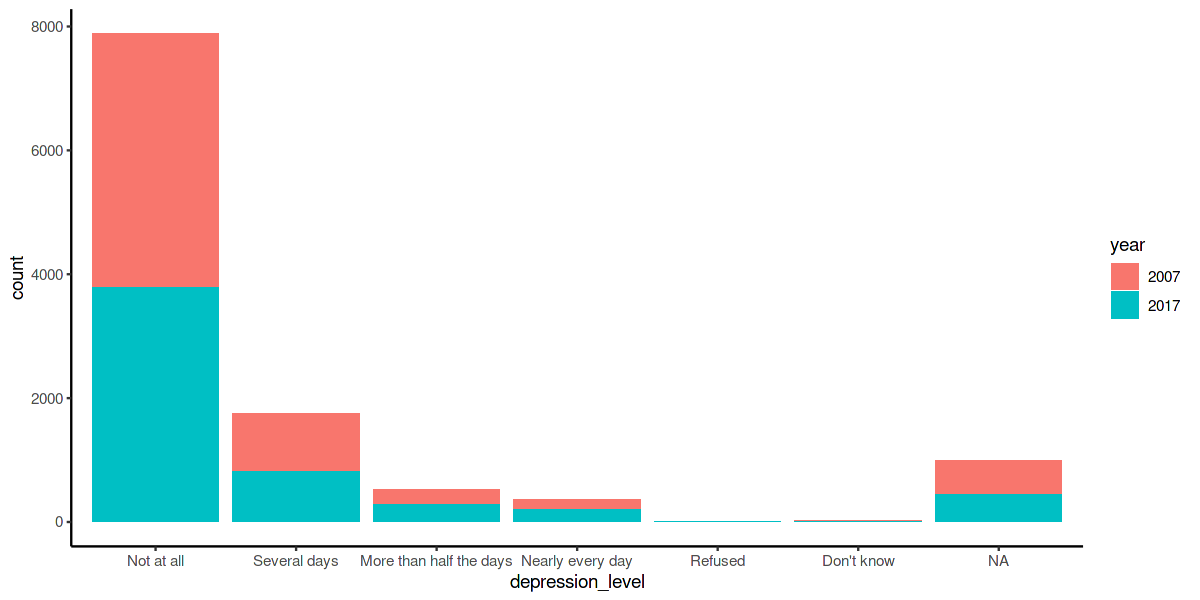

In [58]:
dep_df %>% ggplot + geom_bar(aes(x=depression_level, fill=year))

What are some possible issues with interpreting this plot?

Let's try visualizing this a different way using a "slope graph":

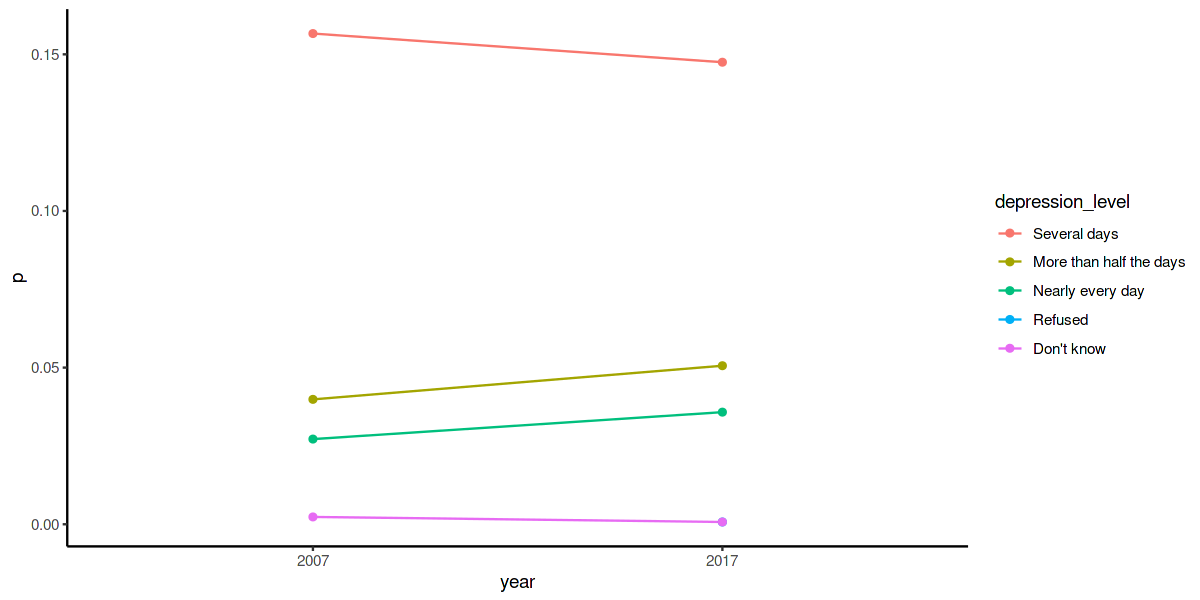

In [66]:
dep_df %>% count(year, depression_level) %>% group_by(year) %>% mutate(p = n / sum(n)) %>% 
    filter(depression_level != "Not at all") %>% 
    ggplot(aes(x=year, y=p, group = depression_level, color = depression_level)) + 
    geom_line() + geom_point()

Are these differences statistically significant?

In [71]:
dep_df %>% lm(depression_level == "More than half the days" ~ year, data = .) %>% summary


Call:
lm(formula = depression_level == "More than half the days" ~ 
    year, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05497 -0.05497 -0.04386 -0.04386  0.95614 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.043861   0.002930  14.969  < 2e-16 ***
year2017    0.011105   0.004215   2.635  0.00844 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2163 on 10541 degrees of freedom
  (985 observations deleted due to missingness)
Multiple R-squared:  0.000658,	Adjusted R-squared:  0.0005632 
F-statistic: 6.941 on 1 and 10541 DF,  p-value: 0.008438


## Formula weighting
- An important issue we've overlooked is that samples in NHANES are not purely random. 
- To get a representative sample of the US, we have to pay attention to the "sampling weights" that are attached to each individual.
- These weights are contained inside the [demographics tables](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics&CycleBeginYear=2007).
- (Note: the weighting procedure is [complicated](https://wwwn.cdc.gov/nchs/nhanes/tutorials/Weighting.aspx). I'm using a crude approximation here.)

This code downloads the demographic information tables. (This code is roughly the same as for downloading the depression tables).

In [78]:
source("nhanes.R")
demo_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/DEMO_E.XPT',
    '2017'='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.XPT'
)
demo_urls %>% map(read_xpt) %>% map(recode_demo_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>%
    bind_rows -> demo_df

Finally, we will also download some information on [physical activity](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PAQ_J.htm):

In [353]:
source("nhanes.R")
paq_urls <- list(
    '2007'='https://wwwn.cdc.gov/Nchs/Nhanes/2007-2008/PAQ_E.XPT',
    '2017'='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PAQ_J.XPT'
)
paq_urls %>% map(read_xpt) %>% map(recode_paq_df) %>% 
    lmap(\(lst) mutate(lst[[1]], year=names(lst)[1])) %>%
    bind_rows -> paq_df

Finally, join all three datasets:

In [354]:
nhanes_unw_df <- left_join(demo_df, dep_df) %>% left_join(paq_df)

Joining with `by = join_by(SEQN, year)`
Joining with `by = join_by(SEQN, year)`


Now generate a weighted sample:

In [355]:
# note: just calling sample_n is not correct!
nhanes_wt_df <- nhanes_unw_df %>% group_by(year) %>% 
    group_map(~ sample_n(.x, 10000, replace = T, weight = WTINT2YR) %>% mutate(year = factor(.y$year))) %>% 
    bind_rows

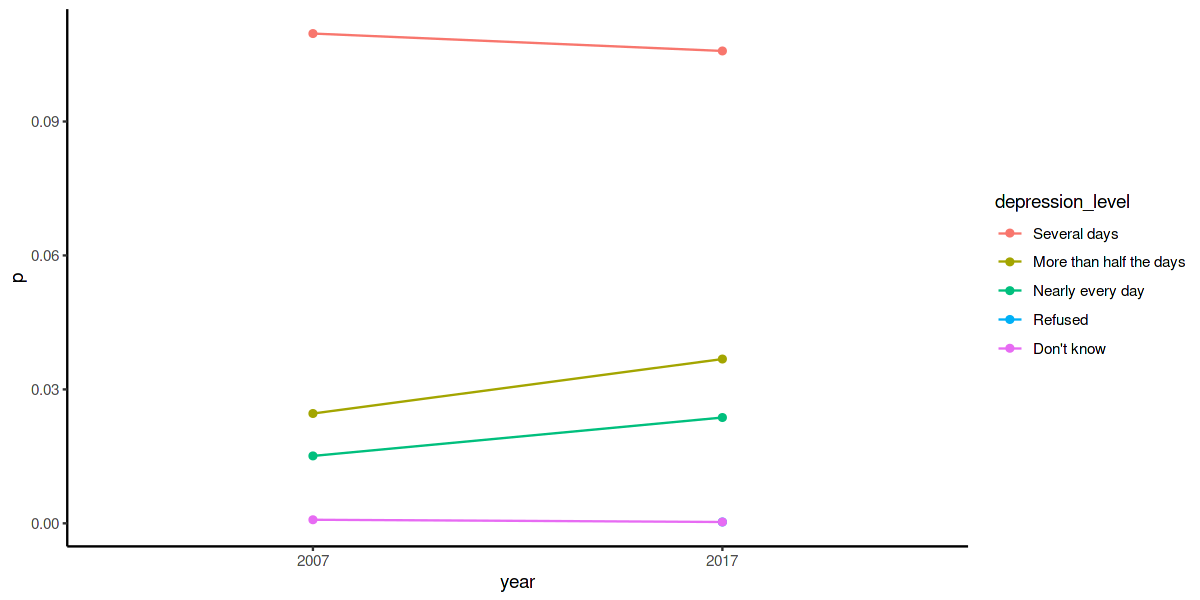

In [280]:
nhanes_wt_df %>% count(year, depression_level) %>% group_by(year) %>% mutate(p = n / sum(n)) %>% 
    filter(depression_level != "Not at all") %>% 
    ggplot(aes(x=year, y=p, group = depression_level, color = depression_level)) + 
    geom_line() + geom_point()

In [281]:
nhanes_wt_df %>% lm(depression_level == "More than half the days" ~ year, data = .) %>% summary


Call:
lm(formula = depression_level == "More than half the days" ~ 
    year, data = .)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.05385 -0.05385 -0.03722 -0.03722  0.96278 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.037222   0.002566  14.504  < 2e-16 ***
year2017    0.016626   0.003599   4.619 3.88e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2086 on 13441 degrees of freedom
  (6557 observations deleted due to missingness)
Multiple R-squared:  0.001585,	Adjusted R-squared:  0.001511 
F-statistic: 21.34 on 1 and 13441 DF,  p-value: 3.885e-06


In [282]:
xtabs(~ year + I(depression_level == "More than half the days"), data = nhanes_wt_df) %>% prop.test


	2-sample test for equality of proportions with continuity correction

data:  .
X-squared = 20.928, df = 1, p-value = 4.768e-06
alternative hypothesis: two.sided
95 percent confidence interval:
 0.009444222 0.023808648
sample estimates:
   prop 1    prop 2 
0.9627780 0.9461516 


## Relationship between depression and age

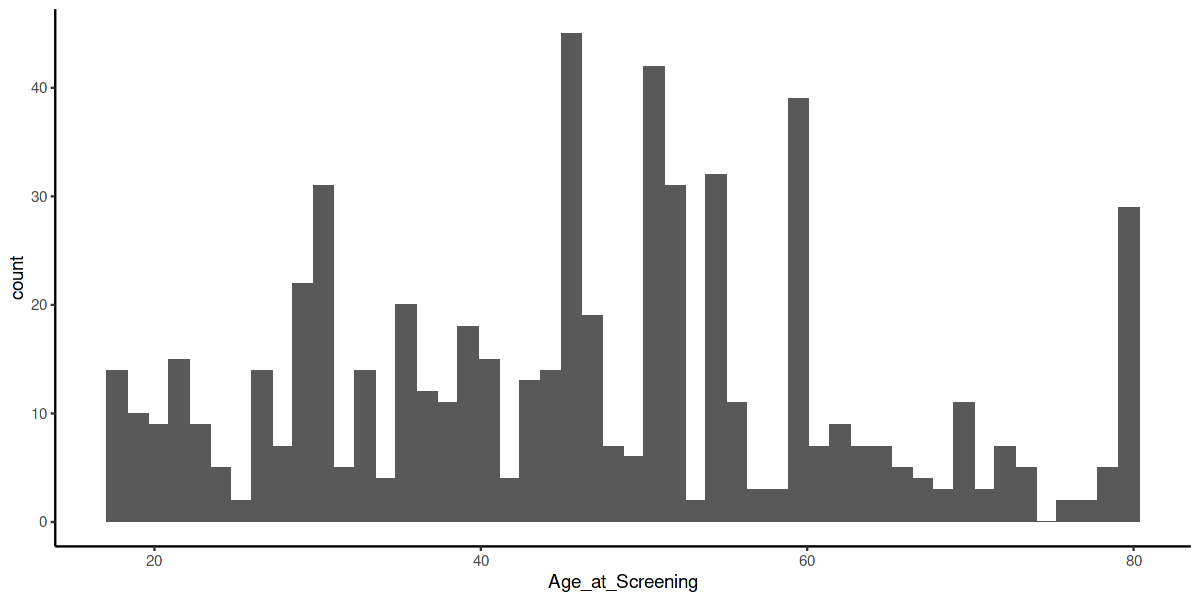

In [283]:
nhanes_wt_df %>% filter(depression_level == "More than half the days") %>% 
    ggplot + geom_histogram(aes(x = Age_at_Screening), bins=50)

In [284]:
nhanes_wt_df %>% glm(depression_level == "More than half the days" ~ Age_at_Screening * year, data = .) %>% 
    summary


Call:
glm(formula = depression_level == "More than half the days" ~ 
    Age_at_Screening * year, data = .)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.05476  -0.05382  -0.03835  -0.03709   0.96425  

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.921e-02  7.371e-03   5.319 1.06e-07 ***
Age_at_Screening          -4.329e-05  1.504e-04  -0.288    0.773    
year2017                   1.611e-02  1.035e-02   1.557    0.120    
Age_at_Screening:year2017  1.198e-05  2.087e-04   0.057    0.954    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.04353163)

    Null deviance: 585.96  on 13442  degrees of freedom
Residual deviance: 585.02  on 13439  degrees of freedom
  (6557 observations deleted due to missingness)
AIC: -3978.4

Number of Fisher Scoring iterations: 2


## Depression scoring
The variables we have about depression are:

In [285]:
select(nhanes_wt_df, depression_level:thoughts_of_death) %>% summary

                depression_level              depression_frequency
 Not at all             :10272   Not at all             :10254    
 Several days           : 2155   Several days           : 2314    
 More than half the days:  614   More than half the days:  472    
 Nearly every day       :  388   Nearly every day       :  393    
 Refused                :    3   Refused                :    2    
 Don't know             :   11   Don't know             :    5    
 NA's                   : 6557   NA's                   : 6560    
                  sleep_issue                   feeling_tired 
 Not at all             :7912   Not at all             :6555  
 Several days           :3315   Several days           :4646  
 More than half the days:1079   More than half the days:1115  
 Nearly every day       :1129   Nearly every day       :1116  
 Refused                :   2   Refused                :   4  
 Don't know             :   3   Don't know             :   4  
 NA's                  

Each question is score on a scale of 0-3, so we can sum them up to build a depression score.

In [358]:
nhanes_wt_df %>% 
    mutate(across(depression_level:thoughts_of_death, \(x) as.integer(x) - 1)) %>% 
    rowwise() %>% 
    mutate(dep_score = sum(c_across(depression_level:thoughts_of_death))) ->
    nhanes_depscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 6561 rows containing non-finite values (`stat_bin()`).”


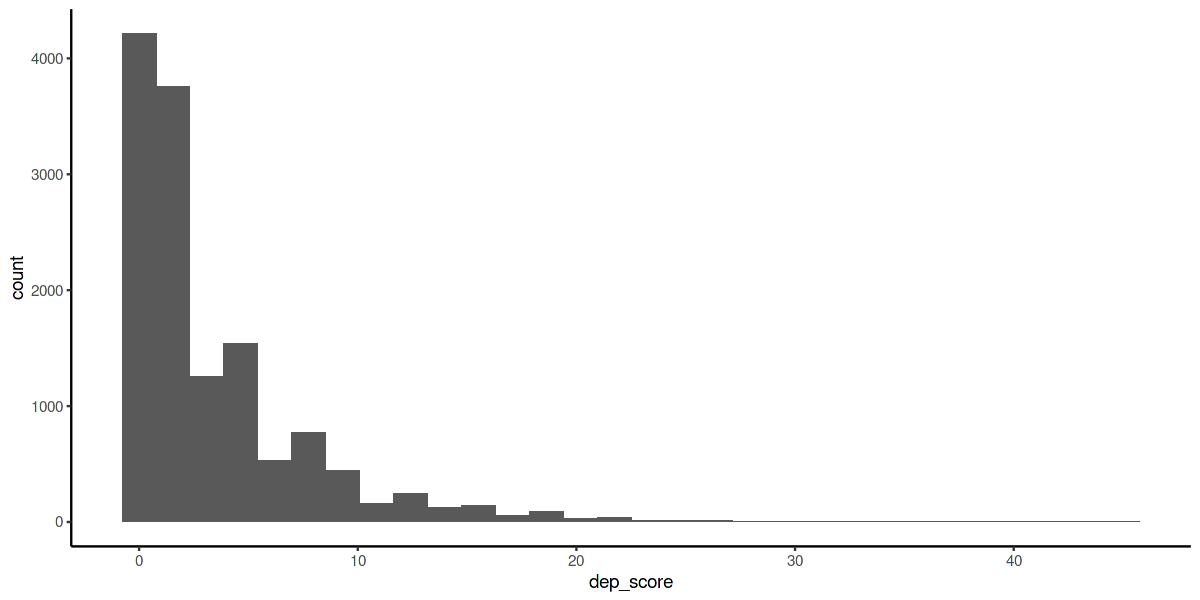

In [288]:
nhanes_depscore %>% ggplot + geom_histogram(aes(x = dep_score))

In [289]:
nhanes_depscore %>% lm(dep_score ~ year * Age_at_Screening, data = .) %>% summary


Call:
lm(formula = dep_score ~ year * Age_at_Screening, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.429 -3.089 -1.292  0.966 42.030 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                3.447736   0.148213  23.262   <2e-16 ***
year2017                   0.103585   0.208059   0.498   0.6186    
Age_at_Screening          -0.005972   0.003023  -1.975   0.0482 *  
year2017:Age_at_Screening -0.000830   0.004197  -0.198   0.8432    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.195 on 13435 degrees of freedom
  (6561 observations deleted due to missingness)
Multiple R-squared:  0.0007442,	Adjusted R-squared:  0.0005211 
F-statistic: 3.335 on 3 and 13435 DF,  p-value: 0.01854


In [290]:
nhanes_depscore %>% drop_na(dep_score, Age_in_Months_at_Screening) %>%
    mutate(age_q = factor(ntile(Age_in_Months_at_Screening, 10))) %>%
    lm(dep_score ~ age_q, data = .) %>% summary


Call:
lm(formula = dep_score ~ age_q, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.689 -2.642 -1.480  1.250 23.779 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.15252    0.16430  19.187  < 2e-16 ***
age_q2      -0.40252    0.23236  -1.732  0.08327 .  
age_q3       0.05031    0.23236   0.217  0.82857    
age_q4       0.28145    0.23236   1.211  0.22584    
age_q5       0.48899    0.23236   2.104  0.03537 *  
age_q6       0.53616    0.23236   2.308  0.02106 *  
age_q7       0.32704    0.23236   1.408  0.15933    
age_q8       0.06796    0.23245   0.292  0.77003    
age_q9      -0.61551    0.23245  -2.648  0.00812 ** 
age_q10     -0.59661    0.23245  -2.567  0.01029 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.144 on 6347 degrees of freedom
Multiple R-squared:  0.00933,	Adjusted R-squared:  0.007925 
F-statistic: 6.642 on 9 and 6347 DF,  p-value: 1.653e-09


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


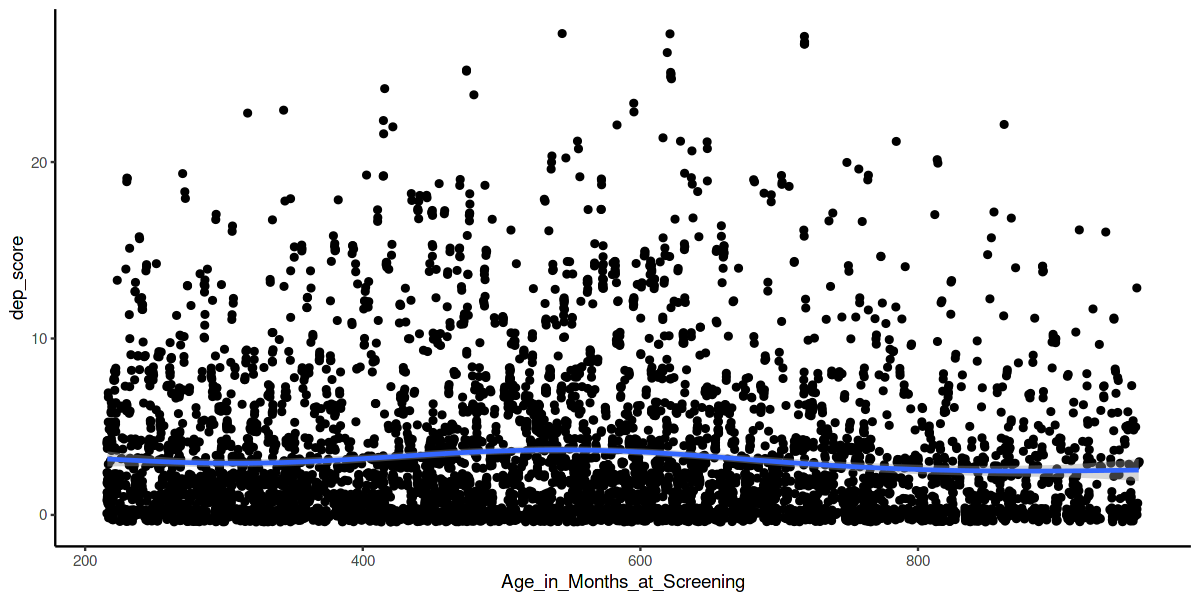

In [292]:
nhanes_depscore %>% drop_na(dep_score, Age_in_Months_at_Screening) %>% 
    ggplot(aes(x=Age_in_Months_at_Screening, y=dep_score)) + geom_jitter() +
    geom_smooth()

## Quantile regression
- Linear regression:

$$\mathbb{E}(Y \mid X) = X\beta$$

- Quantile:

$$Q_{Y|X}(\tau) = \inf \{y: F_{Y|X}(y) \ge \tau \}$$

- Quantile regression:

$$Q_{Y|X}(\tau) = X\beta$$

In [307]:
library(quantreg)
nhanes_depscore %>%
    rq(dep_score ~ Age_at_Screening*year, data = ., tau=.5) %>% summary

Warning message in summary.rq(.):
“350 non-positive fis”



Call: rq(formula = dep_score ~ Age_at_Screening * year, tau = 0.5, 
    data = .)

tau: [1] 0.5

Coefficients:
                          Value   Std. Error t value Pr(>|t|)
(Intercept)               2.00000 0.21617    9.25197 0.00000 
Age_at_Screening          0.00000 0.00441    0.00000 1.00000 
year2017                  0.00000 0.22227    0.00000 1.00000 
Age_at_Screening:year2017 0.00000 0.00481    0.00000 1.00000 

## Depression and income
Are household income and depression related?

In [356]:
xtabs(~ Annual_Household_Income + year, nhanes_depscore)

                       year
Annual_Household_Income 2007 2017
     0-4,999             124  186
     5,000-9,999         299  193
     10,000-14,999       486  289
     15,000-19,999       535  446
     20,000-24,999       654  427
     25,000-34,999      1088  836
     35,000-44,999       879  941
     45,000-54,999       783  675
     55,000-64,999       646  611
     65,000-74,999       631  487
     Over $20,000        343  360
     Under $20,000        51   65
     $75,000 to $99,999 1202 1253
     $100,000 and over  1945 2443
     Refused             139  147
     Don't know          129  185

In [336]:
nhanes_depscore %>% 
    lm(dep_score ~ Annual_Household_Income + year, data = .) %>% 
    summary


Call:
lm(formula = dep_score ~ Annual_Household_Income + year, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-5.816 -2.650 -1.101  1.198 42.143 

Coefficients:
                                          Estimate Std. Error t value Pr(>|t|)
(Intercept)                                4.95191    0.29199  16.959  < 2e-16
Annual_Household_Income5,000-9,999         0.67704    0.37032   1.828 0.067530
Annual_Household_Income10,000-14,999      -0.05254    0.34194  -0.154 0.877893
Annual_Household_Income15,000-19,999      -0.42874    0.33380  -1.284 0.199009
Annual_Household_Income20,000-24,999      -1.30170    0.32455  -4.011 6.08e-05
Annual_Household_Income25,000-34,999      -1.10475    0.31025  -3.561 0.000371
Annual_Household_Income35,000-44,999      -2.05805    0.31092  -6.619 3.75e-11
Annual_Household_Income45,000-54,999      -1.85107    0.31560  -5.865 4.59e-09
Annual_Household_Income55,000-64,999      -2.09454    0.32109  -6.523 7.14e-11
Annual_Household_Income65,000-74,999 

In [338]:
nhanes_dep_hhi <- nhanes_depscore %>% 
 mutate(Annual_Household_Income_Midpoint = case_when(
    Annual_Household_Income == "0-4,999" ~ 2500,
    Annual_Household_Income == "5,000-9,999" ~ 7500,
    Annual_Household_Income == "10,000-14,999" ~ 12500,
    Annual_Household_Income == "15,000-19,999" ~ 17500,
    Annual_Household_Income == "20,000-24,999" ~ 22500,
    Annual_Household_Income == "25,000-34,999" ~ 30000,
    Annual_Household_Income == "35,000-44,999" ~ 40000,
    Annual_Household_Income == "45,000-54,999" ~ 50000,
    Annual_Household_Income == "55,000-64,999" ~ 60000,
    Annual_Household_Income == "65,000-74,999" ~ 70000,
    Annual_Household_Income == "75,000-99,999" ~ 87500,
    Annual_Household_Income == "100,000 and Over" ~ 125000, # Assuming a midpoint for simplicity
    TRUE ~ NA_real_ # Default case if none of the above matches
  ))

In [341]:
lm(dep_score ~ Annual_Household_Income_Midpoint, data = nhanes_dep_hhi) %>% summary


Call:
lm(formula = dep_score ~ Annual_Household_Income_Midpoint, data = nhanes_dep_hhi)

Residuals:
   Min     1Q Median     3Q    Max 
-4.942 -3.196 -1.461  1.609 42.171 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                       5.034e+00  1.128e-01   44.65   <2e-16 ***
Annual_Household_Income_Midpoint -3.676e-05  2.683e-06  -13.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.444 on 7527 degrees of freedom
  (12471 observations deleted due to missingness)
Multiple R-squared:  0.02435,	Adjusted R-squared:  0.02422 
F-statistic: 187.8 on 1 and 7527 DF,  p-value: < 2.2e-16


## Depression and military service
Are military service and depression related?

In [310]:
xtabs(~ Served_in_Armed_Forces + year, data = nhanes_depscore)

                      year
Served_in_Armed_Forces 2007 2017
            Yes         823  629
            No         6770 7167
            Refused       0    1
            Don't know    0    2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1953 rows containing non-finite values (`stat_bin()`).”


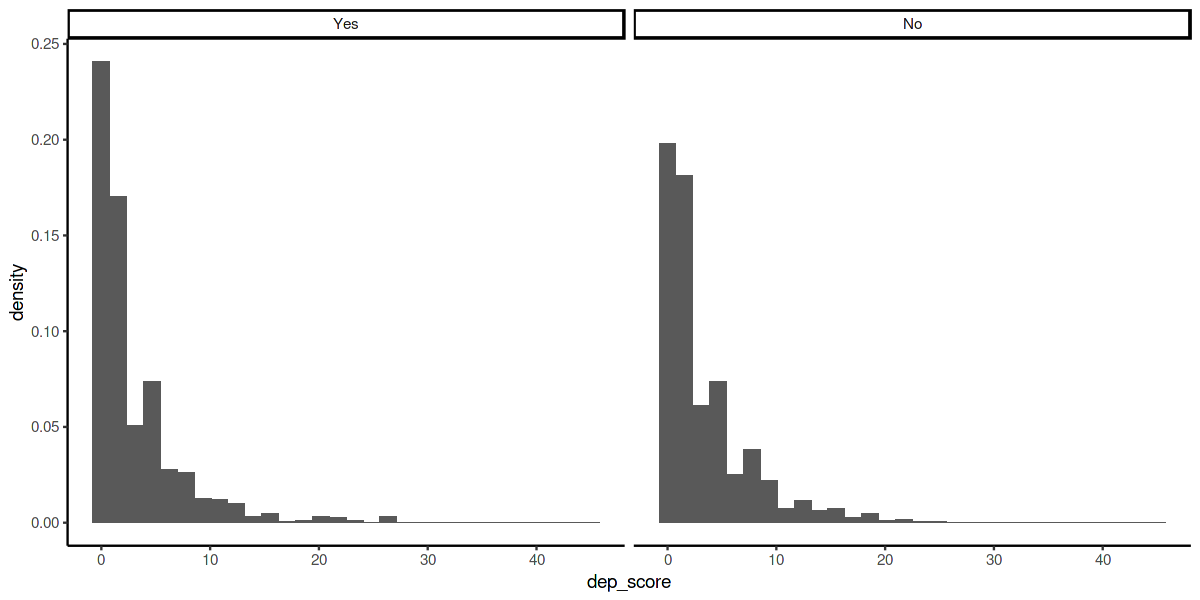

In [315]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    ggplot + geom_histogram(aes(x = dep_score, y = ..density..)) + 
    facet_grid(~ Served_in_Armed_Forces)

In [327]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    lm(dep_score ~ year * Served_in_Armed_Forces, data = .) %>% 
    summary


Call:
lm(formula = dep_score ~ year * Served_in_Armed_Forces, data = .)

Residuals:
   Min     1Q Median     3Q    Max 
-3.248 -3.228 -1.248  0.947 41.772 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         2.7530     0.1525  18.057   <2e-16 ***
year2017                            0.3000     0.2354   1.275   0.2025    
Served_in_Armed_ForcesNo            0.4747     0.1620   2.930   0.0034 ** 
year2017:Served_in_Armed_ForcesNo  -0.2793     0.2474  -1.129   0.2589    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.195 on 13432 degrees of freedom
  (1953 observations deleted due to missingness)
Multiple R-squared:  0.0007699,	Adjusted R-squared:  0.0005467 
F-statistic:  3.45 on 3 and 13432 DF,  p-value: 0.01585


In [331]:
nhanes_depscore %>% filter(Served_in_Armed_Forces %in% c("Yes", "No")) %>% 
    rq(dep_score ~ year * Served_in_Armed_Forces, data = ., tau=0.95) %>% 
    summary


Call: rq(formula = dep_score ~ year * Served_in_Armed_Forces, tau = 0.95, 
    data = .)

tau: [1] 0.95

Coefficients:
                                  Value    Std. Error t value  Pr(>|t|)
(Intercept)                       11.00000  0.88729   12.39733  0.00000
year2017                           0.00000  1.02940    0.00000  1.00000
Served_in_Armed_ForcesNo           2.00000  0.94294    2.12102  0.03394
year2017:Served_in_Armed_ForcesNo -1.00000  1.12089   -0.89215  0.37233

## Depression and exercise
How does exercise affect depression levels?

In [361]:
lm(dep_score ~ Walk_or_Bicycle, data = nhanes_depscore) %>% summary


Call:
lm(formula = dep_score ~ Walk_or_Bicycle, data = nhanes_depscore)

Residuals:
   Min     1Q Median     3Q    Max 
-3.320 -3.056 -1.320  1.680 41.680 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         3.31966    0.04103  80.899  < 2e-16 ***
Walk_or_BicycleYes -0.26409    0.08776  -3.009  0.00262 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.201 on 13414 degrees of freedom
  (6584 observations deleted due to missingness)
Multiple R-squared:  0.0006746,	Adjusted R-squared:  0.0006001 
F-statistic: 9.055 on 1 and 13414 DF,  p-value: 0.002625
